## Paso 1: Cargar liberias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import string
import spacy
from openai import OpenAI
from wordcloud import WordCloud
import json

from spacy.lang.es.stop_words import STOP_WORDS

In [2]:
nlp = spacy.load("es_core_news_lg")

In [3]:
df = pd.read_excel("../datasets/exploration_datasets/silver/silver_df_news_balanced_df.xlsx")

In [4]:
df.head()

,title,category,content,country,newspaper,content_unicode,content_removed_unwanted_elements,content_lowercase,content_sentence_tokenization,content_lowercase_with_no_punctuation,content_without_stopwords,content_tokens,content_lemmes
0,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Se cumplen 10 años desde que ‘Gabo’ falleció.....,Colombia,Semana,Se cumplen 10 años desde que ‘Gabo’ falleció...,Se cumplen 10 anos desde que Gabo fallecio.. E...,se cumplen 10 anos desde que gabo fallecio.. e...,['se cumplen 10 anos desde que gabo fallecio.....,se cumplen 10 anos desde que gabo fallecio el ...,cumplen 10 anos gabo fallecio mundo letras vis...,cumplen 10 anos gabo fallecio mundo letras vis...,"['cumplir', 'ano', 'gabo', 'fallecio', 'mundo'..."
1,"“Tiburón: la historia de un clásico”, el docum...",cultura,"A medio siglo de su estreno, Tiburón vuelve a ...",Colombia,La El Colombiano,"A medio siglo de su estreno, Tiburón vuelve a...","A medio siglo de su estreno, Tiburon vuelve a ...","a medio siglo de su estreno, tiburon vuelve a ...","['a medio siglo de su estreno, tiburon vuelve ...",a medio siglo de su estreno tiburon vuelve a e...,siglo estreno tiburon vuelve escena documental...,siglo estreno tiburon vuelve escena documental...,"['siglo', 'estreno', 'tiburon', 'vuelve', 'esc..."
2,El “boom” de la literatura latinoamericana rev...,cultura,Décadas después del movimiento que convirtió a...,Colombia,Semana,Décadas después del movimiento que convirtio...,Decadas despues del movimiento que convirtio a...,decadas despues del movimiento que convirtio a...,['decadas despues del movimiento que convirtio...,decadas despues del movimiento que convirtio a...,decadas movimiento convirtio realismo magico s...,decadas movimiento convirtio realismo magico s...,"['decada', 'movimiento', 'convirtio', 'realism..."
3,Colombia brilló en Cannes: ‘Un Poeta’ ganó el ...,cultura,La película de Simón Mesa Soto fue galardonada...,Colombia,Semana,La película de Simón Mesa Soto fue galardona...,La pelicula de Simon Mesa Soto fue galardonada...,la pelicula de simon mesa soto fue galardonada...,['la pelicula de simon mesa soto fue galardona...,la pelicula de simon mesa soto fue galardonada...,pelicula simon mesa soto galardonada seccion m...,pelicula simon mesa soto galardonada seccion m...,"['pelicula', 'simon', 'mesa', 'soto', 'galardo..."
4,Este domingo en la FILBo habrá taller familiar...,cultura,"Será un espacio para leer, soñar, reír y refle...",Colombia,Semana,"Será un espacio para leer, soñar, reír y re...","Sera un espacio para leer, sonar, reir y refle...","sera un espacio para leer, sonar, reir y refle...","['sera un espacio para leer, sonar, reir y ref...",sera un espacio para leer sonar reir y reflexi...,espacio leer sonar reir reflexionar respeto em...,espacio leer sonar reir reflexionar respeto em...,"['espacio', 'leer', 'sonar', 'reir', 'reflexio..."


## Paso 2: Remover elementos no deseados

In [5]:
def remove_si_tiene_interes_block(text, domains=None):
    """Remove the 'Si tiene interés...' block robustly, even with malformed emails."""
    if domains is None:
        domains = ["elespectador.com"]

    start_match = re.search(r"Si\s+tiene\s+inter[eé]s", text, flags=re.IGNORECASE)
    if not start_match:
        return text  # nothing to remove

    start_idx = start_match.start()

    last_domain_pos = -1
    last_domain_len = 0
    for d in domains:
        for m in re.finditer(re.escape(d), text[start_idx:], flags=re.IGNORECASE):
            pos = start_idx + m.start()
            if pos > last_domain_pos:
                last_domain_pos = pos
                last_domain_len = len(d)

    if last_domain_pos != -1:
        search_start = last_domain_pos + last_domain_len
        period_match = re.search(r"\.", text[search_start:])
        end_idx = search_start + period_match.end() if period_match else len(text)
    else:
        period_match = re.search(r"\.", text[start_idx:])
        end_idx = start_idx + period_match.end() if period_match else len(text)

    cleaned = text[:start_idx] + " " + text[end_idx:]
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned


def extract_text_without_unwanted_elements(text):
    """
    Cleans text:
    - Removes AI audio text and timestamps
    - Removes 'Lea más sobre...' and 'Si tiene interés...' blocks
    - Removes URLs, emojis, and non-breaking spaces
    - Keeps punctuation, bullet points, and Spanish accents
    """

    # 1️ Remove audio fragments and timestamps
    text = re.sub(
        r"(?:Audio\s+generado\s+con\s+IA\s+de\s+Google[\s\S]{0,200}?(?:\d{1,2}:\d{2}\s*(?:/|\n/\n|\u2215)\s*\d{1,2}:\d{2})?)",
        " ",
        text,
        flags=re.IGNORECASE,
    )
    text = re.sub(r"\d{1,2}:\d{2}\s*(?:/|\n/\n|\u2215)\s*\d{1,2}:\d{2}", " ", text)

    # 2️ Replace non-breaking spaces
    text = text.replace("\xa0", " ")

    # 3 Remove “Lea más sobre...” and “Le puede interesar...” sentences
    text = re.sub(r"(Lea\s+m[aá]s\s+sobre|Le\s+puede\s+interesar)[^.]*\.", " ", text, flags=re.IGNORECASE)

    # 4️ Remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)

    # 5️ Remove the “Si tiene interés…” block
    text = remove_si_tiene_interes_block(text, domains=["elespectador.com"])

    # 6️ Remove unwanted characters but KEEP accents, punctuation, and bullets
    text = re.sub(r"[^A-Za-zÁÉÍÓÚáéíóúÑñÜü0-9\s.,;:!?¿¡\"'()\-]", "", text)

    # 7️ Normalize whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # 8️ Normalize multiple punctuation
    text = re.sub(r"\.{2,}", ".", text)       # collapse ".." or "..."
    text = re.sub(r"([!?;:]){2,}", r"\1", text)

    return text



## Paso 3: Reconocimiento de entidades nombradas

In [6]:
def extract_entities_spacy(text):
    """
    Extract (entity_text, entity_label) pairs from Spanish text,
    keeping original casing for model use.
    """
    doc = nlp(text)
    entities = []
    for ent in doc.ents:
        ent_text = ent.text.strip()
        words = [w.strip(string.punctuation).lower() for w in ent_text.split()]
        if len(words) == 0 or all(word in STOP_WORDS for word in words):
            continue
        if len(ent_text) <= 3:
            continue
        # Keep original text (with case)
        entities.append((ent.text.strip(), ent.label_))
    return entities


## Paso 4: Definir palabras para remover

In [7]:
REMOVE_WORDS = {
    # Basic connectors and determiners
    "de", "del", "la", "las", "el", "los", "y", "a", "en", "al",
    "para", "por", "con", "sin", "sobre", "tras", "entre", "hacia", "hasta",
    "desde", "ante", "bajo", "según", "segun",

    # Articles and pronouns
    "un", "una", "unos", "unas", "lo", "su", "sus", "tu", "tus",
    "mi", "mis", "nuestro", "nuestra", "nuestros", "nuestras",
    "vuestro", "vuestra", "vuestros", "vuestras",
    "este", "esta", "estos", "estas", "ese", "esa", "esos", "esas",
    "aquel", "aquella", "aquellos", "aquellas", "ello",

    # Common verbs (frequent and low semantic value)
    "ser", "es", "era", "eran", "fue", "fueron", "soy", "eres", "somos", "son",
    "estar", "está", "estan", "están", "estaba", "estaban", "estuve", "estuvieron",
    "haber", "hay", "había", "habían", "he", "han", "ha", "haya", "habrá", "habrían",
    "tener", "tiene", "tienen", "tenía", "tenían", "tuvo", "tuvieron", "tendría",
    "hacer", "hace", "hacen", "hacía", "hacían", "hizo", "hicieron", "hará", "harían",
    "poder", "puede", "pueden", "podía", "podían", "podrá", "podrían", "eso"

    # Common functional words
    "que", "se", "ya", "no", "ni", "sí", "si", "tambien", "también",
    "solo", "sólo", "muy", "más", "mas", "menos", "todo", "toda", "todos", "todas",
    "nada", "algo", "algún", "alguna", "algunos", "algunas",
    "cual", "cuál", "cuales", "cuáles", "quien", "quién", "quienes", "quiénes",
    "donde", "dónde", "cuando", "cuándo", "como", "cómo",
    "porque", "porqué", "ya", "entonces", "así", "mismo", "además", "aunque",
    "pero", "sin embargo", "incluso", "también", "pues", "aun", "aún",

    # Filler and journalist/reporting words
    "lea", "lea tambien", "lea también", "según", "segun", "afirmó", "dijo",
    "indicó", "explicó", "comentó", "aseguró", "manifestó", "informó",
    "sostuvo", "declaró", "añadió", "agregó", "señaló", "destacó",
    "recordó", "resaltó", "consideró", "precisó", "recalcó",
    "dicha", "dicho", "asimismo", "finalmente", "actualmente",
    "cabe", "destaca", "afirmó", "indicó", "agregó",

    # Pronouns and reflexives
    "me", "te", "se", "nos", "os", "le", "les", "la", "lo", "las", "los",
    "él", "ella", "ellos", "ellas", "usted", "ustedes", "nosotros", "vosotros",

    # Miscellaneous and temporal words
    "yo", "tú", "usted", "él", "ella", "ellos", "ellas",
    "alguien", "cualquiera", "ninguno", "ninguna", "nunca",
    "siempre", "ahora", "ayer", "hoy", "mañana", "ahí", "aquí", "allí", "allá",
    "entonces", "mientras", "durante", "antes", "después",

    # Common noisy/filler words in scraped news text
    "siga leyendo", "según", "segun", "acuerdo", "ejemplo", "caso", "tipo", "forma",
    "vez", "veces", "parte", "lugar", "día", "días", "año", "años"
}


## Paso 5: Remover las palabras no deseados

In [8]:
def clean_entities(entities):
    """
    Takes a list of (entity_text, entity_label) tuples and removes filler words.
    Returns cleaned list of entity texts.
    """
    cleaned = []
    for text, label in entities:
        words = [w for w in text.split() if w.lower() not in REMOVE_WORDS]
        new_text = " ".join(words).strip()
        if new_text:  # avoid empty results
            cleaned.append(new_text)
    return cleaned


In [9]:
df["content_removed_unwanted_elements_for_bert"] = df["content"].apply(extract_text_without_unwanted_elements)

In [10]:
extract_text_without_unwanted_elements(df["content_removed_unwanted_elements_for_bert"][5])

'El cantante samario sorprenderá junto a una reconocida agrupación en el escenario. Carlos Vives es reconocido como uno de los artistas colombianos con mayor crecimiento y exposición a nivel internacional, pues a través de sus distintos álbumes ha llegado a todos los rincones del mundo y se ha ganado el cariño de millones de personas que se identifican con sus letras y conectan con el ritmo de sus canciones. Además, su recorrido en la industria musical le ha permitido ayudar a nivel económico a diversos territorios e incluso, en compañía de su esposa, creó su propia fundación llamada Tras la perla, con la que ha contribuido a recuperación y restauración de distintos terrenos para los habitantes del Magdalena. Trabajamos para el florecimiento y la conexión de las comunidades a partir de hábitats restaurados y su identidad, su historia y su cultura altamente consolidadas como ejes de su desarrollo integral, se lee en la página web oficial. Es por esto que en la próxima edición de los Pre

In [11]:
# Apply extraction + cleaning
df["entities"] = df["content_removed_unwanted_elements_for_bert"].apply(
    lambda text: clean_entities(extract_entities_spacy(text)) if isinstance(text, str) else []
)

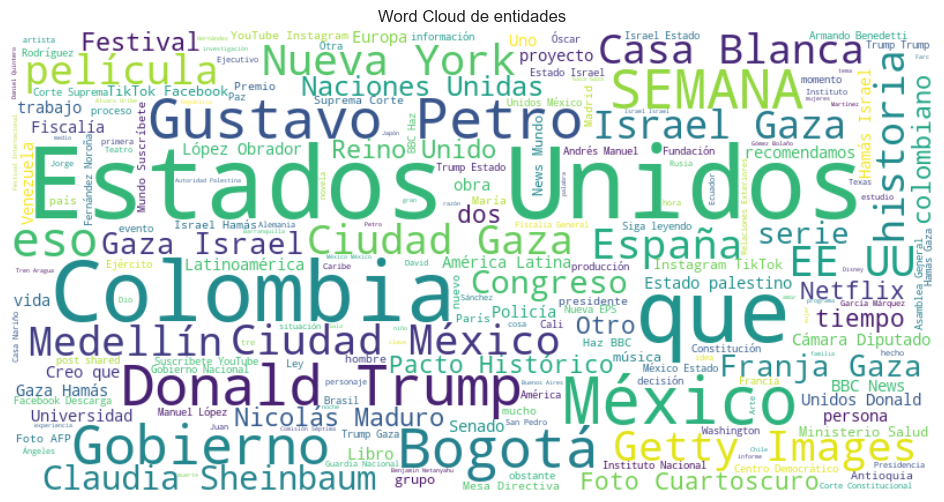

In [12]:
# Flatten entities, keep only the text part
all_entities = [ent[0] if isinstance(ent, tuple) else ent for sublist in df["entities"] for ent in sublist]

# Now you can join them for word cloud
text_for_wc = " ".join(all_entities)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_for_wc)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud de entidades")
plt.show()


In [13]:
selected_df = df[[
    "title",
    "category",
    "country",
    "newspaper",
    "content_removed_unwanted_elements_for_bert",
    "entities"
]].rename(columns={
    "content_removed_unwanted_elements_for_bert": "context"
})

selected_df.head()

,title,category,country,newspaper,context,entities
0,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,Se cumplen 10 años desde que Gabo falleció. El...,"[Gabo, mundo letras, Gabriel García Márquez, c..."
1,"“Tiburón: la historia de un clásico”, el docum...",cultura,Colombia,La El Colombiano,"A medio siglo de su estreno, Tiburón vuelve a ...","[Tiburón, National Geographic, Tiburón, Steven..."
2,El “boom” de la literatura latinoamericana rev...,cultura,Colombia,Semana,Décadas después del movimiento que convirtió a...,"[Décadas, Argentina, Chile, Eternauta, casa Es..."
3,Colombia brilló en Cannes: ‘Un Poeta’ ganó el ...,cultura,Colombia,Semana,La película de Simón Mesa Soto fue galardonada...,"[Simón Mesa Soto, Cierta Mirada Festival Canne..."
4,Este domingo en la FILBo habrá taller familiar...,cultura,Colombia,Semana,"Será un espacio para leer, soñar, reír y refle...","[domingo, Feria Internacional Libro Bogotá, FI..."


In [14]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [15]:
def filtrar_entidades_en_texto(entidades, contenido):
    """Mantener solo las entidades que aparecen en el contenido."""
    if not entidades:
        return []
    return [ent for ent in entidades if str(ent).lower() in contenido.lower()]

def generar_qa_factoid_imposible(contenido, titulo=None, entidades=None, categoria=None, periodico=None):
    """
    Genera pares de QA factoid y también preguntas imposibles en español.
    Devuelve una lista de diccionarios: question, answer, context, is_impossible
    """
    entidades_validas = filtrar_entidades_en_texto(entidades, contenido)

    prompt = f"""
Eres un generador de pares de preguntas y respuestas extractivas en español.
Genera 5 pares de QA factoid y 2 preguntas imposibles.
Usa solo las entidades que aparecen en el contenido.

Devuelve **únicamente** una lista JSON válida de objetos con los campos:
- "question": str
- "answer": str
- "is_impossible": bool

Ejemplo de formato:
[
  {{"question": "¿Qué país organizó la conferencia?", "answer": "Colombia", "is_impossible": false}},
  {{"question": "¿Quién dirigió la NASA?", "answer": "", "is_impossible": true}}
]

Datos del artículo:
Título: {titulo}
Categoría: {categoria}
Periódico: {periodico}
Entidades: {entidades_validas}
Contenido: {contenido}
"""

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # or "gpt-5-mini"
        messages=[{"role": "user", "content": prompt}],
        temperature=0.2,
    )

    raw_output = response.choices[0].message.content.strip()

    # Try to extract and parse JSON safely
    try:
        start = raw_output.find("[")
        end = raw_output.rfind("]") + 1
        json_str = raw_output[start:end]
        qa_pairs = json.loads(json_str)
        for qa in qa_pairs:
            qa["context"] = contenido
        return qa_pairs
    except Exception as e:
        print("Error generando QA:", e)
        print("Output del modelo:", raw_output)
        return []

In [16]:
# --- Tu DataFrame original (ejemplo) ---
# df = selected_df (ya filtrado)
# df.columns → ["title", "category", "country", "newspaper", "context", "entities"]

# 1️⃣ Filtrar filas con entidades no vacías
filtered_df = selected_df[
    (~selected_df["entities"].isna()) &
    (selected_df["entities"].astype(str).str.strip() != "")
]

In [17]:
# 2️⃣ Tomar una muestra aleatoria de 10
sample_df = filtered_df.sample(n=10, random_state=42)

# 3️⃣ Generar QA para cada fila
todos_qa = []

In [18]:
sample_df

,title,category,country,newspaper,context,entities
3472,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,¿Te sientes con suerte? ¡Descubre a continuaci...,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
1213,"Esta es la advertencia de la SIC a Nequi, Davi...",economia,Colombia,La El Colombiano,La Superintendencia emitió una circular dirigi...,"[Superintendencia, través circular, Superinten..."
2915,Cambio en estatutos y accionistas a punto de c...,salud,Colombia,La El Espectador,"En medio de la turbulencia que vive Nueva EPS,...","[Nueva EPS, Gustavo Petro, cajas compensación,..."
17,"De Morat a las letras, Simón Vargas lanza su l...",cultura,Colombia,La El Colombiano,"Se trata de una serie de cuentos, trece en tot...","[España, Simón, Sergio Villamizar Simón Vargas..."
2325,Movilidad hoy: cesa manifestación y se normali...,politica,Colombia,La El Espectador,Para planear mejor su ruta este 29 de septiemb...,"[Espectador, Bogotá, Conozca, Transmilenio, Bo..."
3728,Parte de la Flotilla Sumud continúa su avance ...,internacional,Mexico,El Excelsior,La flotilla Global Sumud sigue rumbo a Gaza pe...,"[Global Sumud, Gaza, Greta Thunberg, flotilla,..."
134,Se inició la edición número 15 del Festival de...,cultura,Colombia,La El Espectador,"Mientras haya tinta, el corto animado de El Es...","[Espectador, Guillermo Cano Isaza, Festiver, E..."
1057,Festival Estéreo Picnic: con el anuncio de Tom...,cultura,Colombia,Semana,"El químico loco de la guitarra, ícono de Rage ...","[Rage Against the Machine, Parque Simón Bolíva..."
869,"Tejiendo creatividad, así fue el desfile en el...",cultura,Colombia,Semana,Las prendas fueron elaboradas bajo la direcció...,"[Alejandro Crocker, Tejiendo Creatividad, inic..."
3023,Las claves para que hablar de suicidio lleve a...,salud,Colombia,El Tiempo,"El foro 'Voces Sin Estigma', realizado en la C...","[Casa Editorial, Hablar suicidio, foro Voces, ..."


In [19]:
for _, row in sample_df.iterrows():
    qas = generar_qa_factoid_imposible(
        contenido=row["context"],
        titulo=row["title"],
        entidades=row["entities"],
        categoria=row["category"],
        periodico=row["newspaper"]
    )
    for qa in qas:
        qa["title"] = row["title"]
        qa["category"] = row["category"]
        qa["country"] = row["country"] if "country" in row else None
        qa["newspaper"] = row["newspaper"]
        qa["context"] = row["context"]
        qa["entities"] = row["entities"]
        todos_qa.append(qa)

# 4️⃣ Convertir a DataFrame final
qa_df = pd.DataFrame(todos_qa)
print(qa_df.head())

                                            question  \
0  ¿Qué evento celebra la Lotería Nacional el 24 ...   
1  ¿Cuál es el premio mayor del Sorteo Zodiaco Es...   
2  ¿Qué signo del zodiaco tiene un reintegro en e...   
3  ¿Dónde se pueden cobrar los premios del Sorteo...   
4       ¿En qué año fue fundada la Lotería Nacional?   

                                              answer  is_impossible  \
0                       Sorteo Zodiaco Especial 1716          False   
1                               11 millones de pesos          False   
2                                                Leo          False   
3  Oficinas de la Lotería Nacional para la Asiste...          False   
4                                               1770          False   

                                             context  \
0  ¿Te sientes con suerte? ¡Descubre a continuaci...   
1  ¿Te sientes con suerte? ¡Descubre a continuaci...   
2  ¿Te sientes con suerte? ¡Descubre a continuaci...   
3  ¿Te sient

In [20]:
qa_df

,question,answer,is_impossible,context,title,category,country,newspaper,entities
0,¿Qué evento celebra la Lotería Nacional el 24 ...,Sorteo Zodiaco Especial 1716,False,¿Te sientes con suerte? ¡Descubre a continuaci...,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
1,¿Cuál es el premio mayor del Sorteo Zodiaco Es...,11 millones de pesos,False,¿Te sientes con suerte? ¡Descubre a continuaci...,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
2,¿Qué signo del zodiaco tiene un reintegro en e...,Leo,False,¿Te sientes con suerte? ¡Descubre a continuaci...,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
3,¿Dónde se pueden cobrar los premios del Sorteo...,Oficinas de la Lotería Nacional para la Asiste...,False,¿Te sientes con suerte? ¡Descubre a continuaci...,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
4,¿En qué año fue fundada la Lotería Nacional?,1770,False,¿Te sientes con suerte? ¡Descubre a continuaci...,Lotería Nacional: Resultados del Sorteo Zodiac...,cultura,Mexico,El Excelsior,"[domingo 24 agosto, Lotería Nacional, Sorteo Z..."
...,...,...,...,...,...,...,...,...,...
65,¿Qué porcentaje crecieron los intentos de suic...,200 por ciento,False,"El foro 'Voces Sin Estigma', realizado en la C...",Las claves para que hablar de suicidio lleve a...,salud,Colombia,El Tiempo,"[Casa Editorial, Hablar suicidio, foro Voces, ..."
66,¿Cuál es la tercera causa de muerte en persona...,suicidio,False,"El foro 'Voces Sin Estigma', realizado en la C...",Las claves para que hablar de suicidio lleve a...,salud,Colombia,El Tiempo,"[Casa Editorial, Hablar suicidio, foro Voces, ..."
67,¿Qué institución aprobó una operación de crédi...,CAF,False,"El foro 'Voces Sin Estigma', realizado en la C...",Las claves para que hablar de suicidio lleve a...,salud,Colombia,El Tiempo,"[Casa Editorial, Hablar suicidio, foro Voces, ..."
68,¿Qué se necesita para prevenir el suicidio seg...,,True,"El foro 'Voces Sin Estigma', realizado en la C...",Las claves para que hablar de suicidio lleve a...,salud,Colombia,El Tiempo,"[Casa Editorial, Hablar suicidio, foro Voces, ..."


In [21]:
qa_df["title"][30]

'Movilidad hoy: cesa manifestación y se normaliza tránsito en la Autonorte'

In [22]:
qa_df["newspaper"][30]

'La El Espectador'

In [23]:
qa_df["category"][30]

'politica'

In [24]:
qa_df["context"][30]

'Para planear mejor su ruta este 29 de septiembre, El Espectador le cuenta en vivo cómo avanza la movilidad en Bogotá. Conozca el pico y placa para hoy, cómo está operando Transmilenio y las novedades en las principales vías de la capital. . Bogotá es una de las ciudades con el peor tráfico vehicular de Latinoamérica. Y, ahora, con la serie de obras que se adelantan en los principales corredores de la capital, mucho más. Para planear mejor su ruta este 29 de septiembre y llegar a tiempo, les contamos en vivo cómo avanza la movilidad, el pico y placa para hoy, qué vías están cerradas; rutas alternas y cómo opera Transmilenio y las principales novedades en las vías de la ciudad. Pico y placa para hoy Para este 29 de septiembre, la restricción aplica para vehículos con placa terminada en 6-7-8-9 y 0. Recuerde que la medida empieza a las 6:00 a. m. y termina a las 9:00 p. m. Esta restricción también aplica para los taxis con placa terminada en 5 y 6. Manifestantes llegan a la calle 73 con 

In [25]:
qa_df["question"][30]

'¿A qué hora comienza la restricción de pico y placa?'

In [26]:
qa_df["answer"][30]

'6:00 a. m.'

In [27]:
GOLD_PATH   = "../datasets/exploration_datasets/gold/"

In [28]:
qa_df_total_data = []

for _, row in filtered_df.iterrows():
    qas = generar_qa_factoid_imposible(
        contenido=row["context"],
        titulo=row["title"],
        entidades=row["entities"],
        categoria=row["category"],
        periodico=row["newspaper"]
    )
    for qa in qas:
        qa["title"] = row["title"]
        qa["category"] = row["category"]
        qa["country"] = row["country"]
        qa["newspaper"] = row["newspaper"]
        qa["context"] = row["context"]
        qa["entities"] = row["entities"]
        qa_df_total_data.append(qa)

qa_df = pd.DataFrame(qa_df_total_data)
print(qa_df.columns)

Index(['question', 'answer', 'is_impossible', 'context', 'title', 'category',
       'country', 'newspaper', 'entities'],
      dtype='object')


In [29]:
qa_df.head()

,question,answer,is_impossible,context,title,category,country,newspaper,entities
0,¿Qué enfermedad padecía Gabriel García Márquez?,cáncer linfático,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
1,¿Dónde nació Gabriel García Márquez?,"Aracataca, Colombia",False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
2,¿Qué obra maestra publicó García Márquez en 1967?,Cien años de soledad,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
3,¿Qué premio recibió García Márquez en 1982?,Premio Nobel de Literatura,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."
4,¿Cuántos años luchó García Márquez contra su e...,15 años,False,Se cumplen 10 años desde que Gabo falleció. El...,¿Qué enfermedad sufrió Gabriel García Márquez ...,cultura,Colombia,Semana,"[Gabo, mundo letras, Gabriel García Márquez, c..."


In [30]:
qa_df.count()

question         30286
answer           30286
is_impossible    30286
context          30286
title            30286
category         30286
country          30286
newspaper        30286
entities         30286
dtype: int64

In [31]:
# 4️⃣ Save to file (you can pick one or both)
qa_df.to_csv(os.path.join(GOLD_PATH,"generated_qa_pairs.csv"), index=False, encoding="utf-8-sig")

In [32]:
qa_df.to_excel(os.path.join(GOLD_PATH,"generated_qa_pairs.xlsx"), index=False)

In [33]:
qa_df.to_json(os.path.join(GOLD_PATH,"generated_qa_pairs.json"), orient="records", lines=True)

In [34]:
qa_df.tail()

,question,answer,is_impossible,context,title,category,country,newspaper,entities
30281,¿Qué organización describe distintos tipos de ...,Organización Mundial de la Salud (OMS),False,Las vacunas enseñan al organismo a producir an...,Cómo funcionan las vacunas y qué pasa en tu cu...,salud,Mexico,El Excelsior,"[Fundación Huésped, protección, doctor Paul Th..."
30282,¿Cuál es el propósito de las vacunas según la ...,estimular al organismo para que produzca defen...,False,Las vacunas enseñan al organismo a producir an...,Cómo funcionan las vacunas y qué pasa en tu cu...,salud,Mexico,El Excelsior,"[Fundación Huésped, protección, doctor Paul Th..."
30283,¿Qué fenómeno se conoce como inmunidad colectiva?,la protección a los más vulnerables de la soci...,False,Las vacunas enseñan al organismo a producir an...,Cómo funcionan las vacunas y qué pasa en tu cu...,salud,Mexico,El Excelsior,"[Fundación Huésped, protección, doctor Paul Th..."
30284,¿Qué tipo de protección se logra con la admini...,,True,Las vacunas enseñan al organismo a producir an...,Cómo funcionan las vacunas y qué pasa en tu cu...,salud,Mexico,El Excelsior,"[Fundación Huésped, protección, doctor Paul Th..."
30285,¿Cuántas muertes evitan las vacunas cada año e...,,True,Las vacunas enseñan al organismo a producir an...,Cómo funcionan las vacunas y qué pasa en tu cu...,salud,Mexico,El Excelsior,"[Fundación Huésped, protección, doctor Paul Th..."


In [35]:
#with open(os.path.join(GOLD_PATH,"generated_qa_pairs.csv"), "w", encoding="utf-8") as f:
#    json.dump(qa_df_total_data, f, ensure_ascii=False, indent=2)